# Experiment calculations 🧪

In [ ]:
import pandas as pd
import numpy as np

import scipy.stats as stats
import statsmodels.stats.api as sms
from statsmodels.stats.proportion import proportions_ztest
import math

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 6]

In [ ]:
def sample_required_estimate(p0, nn, power=0.8, alpha=0.05, power_curves=False):

  '''
  INPUT:
  - p0 as the sample mean used for measure of success (float)
  - nn as the estimated average to be enrolled into the experiment (int)
  - power as the probability of a type II error default as 0.8
  - alpha as significance level or probability of type 1 error default as 0.05

  More info:
  https://www.statsmodels.org/dev/generated/statsmodels.stats.power.NormalIndPower.solve_power.html

  OUTPUT:
  - Sample size per variant group required per given period table and estimated runtime (pandas df)

  '''

  # Minimum detectable lifts
  lift_range = np.linspace(0.01, 0.2, 10)

  p1 = p0 * (1 + lift_range)

  req_n = []

  analysis = sms.NormalIndPower()

  sample_n = []
  run_time = []
  effect_sizes = []

  # get sample size
  for i in range(len(lift_range)):

      es = sms.proportion_effectsize(p0, p1[i])
      effect_sizes.append(es)
      result = analysis.solve_power(effect_size = es,
                                    power = power,
                                    alpha = alpha,
                                    nobs1 = None)

      sample_n.append(result)

  if power_curves is True:

    # power curves
    begin = 0
    end = -1
    division_factor = 250
    effect_sizes = np.array(effect_sizes)
    samples = np.array(range(math.ceil(sample_n[end]),math.ceil(sample_n[begin]/division_factor)),dtype=int)
    fig = analysis.plot_power(dep_var='nobs', nobs= samples, effect_size= effect_sizes)
    fig.set_size_inches(8, 6)
    plt.legend(loc='best',bbox_to_anchor= (1.02, 1.0))

  else:
    pass

  # get running time of the experiment
  for i in sample_n:
      runtime_days = 3 * i / nn
      run_time.append(runtime_days)

  df = pd.DataFrame()

  # required number of submissions
  df['n'] = sample_n

  # lift in conversion rate
  df['lift'] = lift_range

  # control group conversion rate
  df['p1'] = p0

  # treatment group conversion rate target
  df['p2'] = p1

  # run_time in days
  df['run_time'] = run_time

  return df

In [ ]:
def calculate_ztest(visitors_a, visitors_b, conversions_a, conversions_b
                    , alpha=0.05, dist_plot=False):

  '''
  INPUT:
  - visitors_a as the count of visitors for group a (int)
  - visitors_b as the count of visitors for group b (int)
  - conversions_a as the count of visitors who converted of group a (int)
  - conversions_b as the count of visitors who converted of group b (int)

  More info:
  https://www.statsmodels.org/dev/generated/statsmodels.stats.proportion.proportions_ztest.html

  OUTPUT:
  - print statement of p-value

  '''

  # successes of control vs variant 2
  count = np.array([conversions_a, conversions_b])

  # total group n of observations of control vs variant 2
  n_obs = np.array([visitors_a, visitors_b])

  a_cr = count[0] / n_obs[0]
  b_cr = count[1] / n_obs[1]

  lift = b_cr - a_cr

  # get p-value
  stat, pval = proportions_ztest(count, n_obs, alternative='two-sided')

  print('Conversion rate for group A is: ' + str(a_cr))
  print('Conversion rate for group B is: ' + str(b_cr))
  print('P-value: ' + '{0:0.3f}'.format(pval))
  print('Alpha: ' + str(alpha))
  print('')

  if pval < alpha:
    print('P-value is less than alpha. Test result is significant.')
    print('We reject the null hypothesis')
    print('You can be '+ str((1 - alpha)*100) + '% confident that this result is a consequence of the changes you made and not a result of random chance.')
  else:
    print('Test result not significant.')
    print('Do not reject the null hypothesis')
    print('')
  print('')

  if dist_plot is True:

    size_a = count[0]
    size_b = count[1]
    prob_b = 0.08

    # distribution for the null hypothesis, h0
    # and alternative hypothesis, h1
    h0 = stats.norm(loc = 0, scale = 1)
    h1 = stats.norm(loc = (1 - stat), scale = 1)

    # points that are greater than the zscore for the
    # specified significance level
    x = np.linspace(-5, 6, num = 100)
    threshold = h0.ppf(1 - alpha)
    mask = x > threshold

    # power is the area after the threshold, i.e.
    # 1 - the cumulative distribution function of that point
    power = np.round(1 - h1.cdf(threshold), 2)

    hypotheses = [h1, h0]
    labels = ['$H_1$ is true', '$H_0$ is true']
    for hypothesis, label in zip(hypotheses, labels):
        y = hypothesis.pdf(x)
        line = plt.plot(x, y, label = label)
        plt.fill_between(x = x[mask], y1 = 0.0, y2 = y[mask],
                         alpha = 0.2, color = line[0].get_color())

    plt.legend()
    plt.tight_layout()
    plt.show()

  else:
    pass

,n,lift,p1,p2,run_time
0,192030.185094,0.010000,0.45,0.4545,192.030185
1,19873.178724,0.031111,0.45,0.4640,19.873179
2,7063.337691,0.052222,0.45,0.4735,7.063338
3,3586.197719,0.073333,0.45,0.4830,3.586198
4,2164.189818,0.094444,0.45,0.4925,2.164190
5,1446.680716,0.115556,0.45,0.5020,1.446681
6,1034.738494,0.136667,0.45,0.5115,1.034738
7,776.534824,0.157778,0.45,0.5210,0.776535
8,604.056962,0.178889,0.45,0.5305,0.604057
9,483.138446,0.200000,0.45,0.5400,0.483138


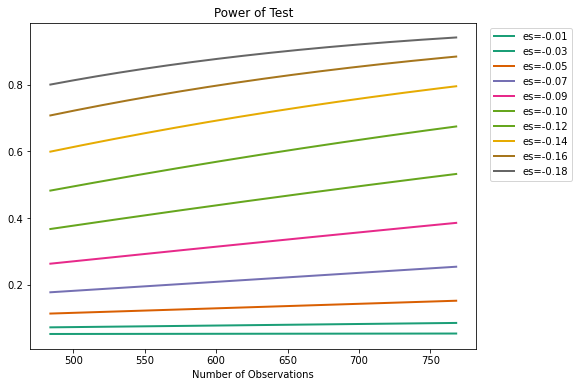

In [ ]:
  # INPUT:
  # - p0 as the sample mean used for measure of success (float)
  # - nn as the estimated average to be enrolled into the experiment (int)
  # - power as the probability of a type II error default as 0.8
  # - alpha as significance level or probability of type 1 error default as 0.05

  # More info:
  # https://www.statsmodels.org/dev/generated/statsmodels.stats.power.NormalIndPower.solve_power.html

  # OUTPUT:
  # - Sample size per variant group required per given period table and estimated runtime (pandas df)

sample_required_estimate(0.45, 3000, power_curves=True)

  # Look used for estimate conversion rate and weekly phone verified customer count:
  # https://looker.corp.luno.com/explore/luno/users?qid=sWS21PS5daydGxZY8hSCd3&origin=share-slug

In [ ]:
  # INPUT:
  # - visitors_a as the count of visitors for group a (int)
  # - visitors_b as the count of visitors for group b (int)
  # - conversions_a as the count of visitors who converted of group a (int)
  # - conversions_b as the count of visitors who converted of group b (int)

  # More info:
  # https://www.statsmodels.org/dev/generated/statsmodels.stats.proportion.proportions_ztest.html

  # OUTPUT:
  # - print statement of p-value

# calculate_ztest(2500, 2500, 1350, 1400, dist_plot=True)